# v3_cord.ipynb

A copy of v3_normal where units and connections were removed in order to produce an isolated spinal cord controlling the arm.

At this point (July 22nd, 2020), v3_cordB has much cleaner code.

See July 17th, 2020 entry.

In [1]:
%cd ../..
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
%load_ext Cython

In [3]:
%%cython
from draculab import *

In [4]:
##################################
####### Create the network #######
##################################

# First the network object, the plant, the list of coordinates
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }
P_params = {  'type' : plant_models.bouncy_planar_arm_v3,
          'mass1': 1.,
          'mass2': 1.,
          's_min' : -0.8,
          'p1' : (-0.01, 0.04),
          'p2' : (0.29, 0.03),
          'p3' : (0., 0.05),
          'p5' : (0.01, -0.05),
          'p10': (0.29, 0.03),
          'init_q1': 0.,
          'init_q2': np.pi/2.,
          'init_q1p': 0.,
          'init_q2p': 0.,
          'g': 0.0,
          'mu1': 3.,
          'mu2': 3.,
          'l_torque' : 0.01,
          'l_visco' : 0.01,
          'g_e' : 2.*np.array([10., 20., 20., 10., 20., 20.]),
          'l0_e' : [1.]*6,
          'Ia_gain' : 2.5*np.array([3.,10.,10., 3.,10.,10.]),
          'II_gain' : 2.*np.array([3., 8., 8., 3., 8., 8.]),
          'Ib_gain' : 1.,
          'T_0' : 10.,
          'k_pe_e' : 5.,  #8
          'k_se_e' : 25., #13
          'b_e' : 5.,
          'g_s' : 0.02,
          'k_pe_s' : 2., 
          'k_se_s' : 2.,
          'g_d' : 0.01,
          'k_pe_d' : .2, #.1,
          'k_se_d' : 1., #2.,
          'b_s' : .5,
          'b_d' : 2.,#3.,
          'l0_s': .7,
          'l0_d': .8,
          'fs' : 0.1,
          'se_II' : 0.5,
          'cd' : 0.5,
          'cs' : 0.5,
          'tau' : 0.1   # ficticious time constant used in create_freqs_steps
           }
net = network(net_params)

# We organize the spinal connections through 4 types of symmetric relations
# these lists are used to set intraspinal connections and test connection matrices
antagonists = [(0,3), (1,2), (4,5)]
part_antag = [(0,2),(0,5), (3,4), (1,3)]
synergists = [(0,1), (0,4), (2,3), (3,5)]
part_syne = [(1,4), (2,5)]
self_conn = [(x,x) for x in range(6)]

antagonists += [(p[1],p[0]) for p in antagonists]
part_antag += [(p[1],p[0]) for p in part_antag]
synergists += [(p[1],p[0]) for p in synergists]
part_syne += [(p[1],p[0]) for p in part_syne]
all_pairs = [(i,j) for i in range(6) for j in range(6)]
#unrelated = set(all_pairs) - set(antagonists) - set(part_antag) - set(synergists) - set(part_syne) - set(self_conn)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# UNIT PARAMETER DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
par_heter = 0.001 # range of heterogeneity as a fraction of the original value
#randz1 = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz6 = lambda : (1. + par_heter*(np.random.rand(6)-0.5))
randz12 = lambda : (1. + par_heter*(np.random.rand(12)-0.5))
randz18 = lambda : (1. + par_heter*(np.random.rand(18)-0.5))
randz36 = lambda : (1. + par_heter*(np.random.rand(36)-0.5))

AL_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.6 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.1 * randz6(),
             'tau' : 0.05 * randz6() }
CE_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'thresh' : 0. * randz6(),
             'slope' : 1.5 * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.1, #0.02 * randz6(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : 50.,
             'custom_inp_del' : 15, # placeholder values
             'custom_inp_del2': 30,
             'integ_amp' : 1.87, #.5,
             'integ_decay' : 1.33,
             'adapt_amp' : 10., #8.,
             'delay' : 0.2,
             'des_out_w_abs_sum' : 1. }
CI_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'thresh' : 0.5 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.05, #0.01 * randz6(), #0.02 * randz6(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : 50.,
             'custom_inp_del' : 15, # placeholder values
             'custom_inp_del2': 30,
             'integ_amp' : 1.87, #.5,
             'integ_decay' : 1.33,
             'adapt_amp' : 10., #8.,
             'delay' : 0.2,
             'des_out_w_abs_sum' : 1. }
INP_params = {'type' : unit_types.source,
              'init_val' : 0.5,
              'tau_fast' : 0.02,
              'tau_mid' : 0.1,
              'function' : lambda t: None }
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTION DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# AL to P ------------------------------------------------
AL__P_conn = {'inp_ports' : list(range(6)),
             'delays': 0.01 }
AL__P_syn = {'type': synapse_types.static,
            'init_w' : 1. }
# CE, CI to AL ----------------------------------------------
CE__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__AL_syn = {'type' : synapse_types.static,
              'init_w' : [1., 1., 1., 1., 1., 1.] }
CI__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__AL_syn = {'type' : synapse_types.static,
              'init_w' : -1. }
# CE,CI to CE,CI  ------------------------------------------------
CE__CI_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__CE_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__CI_syn = {'type' : synapse_types.static,
              'inp_ports' : 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
              'init_w' : 1. }
CI__CE_syn = {'type' : synapse_types.static, #static, #corr_inh,
              'inp_ports' : 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
              'lrate' : .0,
              'des_act' : 0.5,
              'init_w' : -4. }
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn_antag = {'type' : synapse_types.static, #bcm,
                  'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                  'init_w' : 2., #16.,
                  'lrate' : 1.,
                  'des_act' : .5 }
C__C_syn_p_antag = {'type' : synapse_types.static, #bcm,
                  'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                  'init_w' : .5, # 8.,
                  'lrate' : 1.,
                  'des_act' : 0.2 }
C__C_syn_syne = {'type' : synapse_types.static,
                 'inp_ports': 1,
                 'lrate' : 1.,
                 'init_w' : .5 }
C__C_syn_p_syne = {'type' : synapse_types.static,
                   'inp_ports': 1,
                   'lrate' : 1.,
                   'init_w' : 0.2 }
C__C_syn_null_lat = {'type' : synapse_types.static, # connection with static weight zero
                   'inp_ports': 1,
                   'lrate' : 1.,
                   'init_w' : 0. }
C__C_syn_null_aff = {'type' : synapse_types.static, # connection with static weight zero
                   'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                   'lrate' : 1.,
                   'init_w' : 0. }
INP_CE_conn = {'rule' : 'all_to_all',
            'delay' : 0.01 }
INP_CE_syn = {'type' : synapse_types.static,
             'inp_ports': 0,
             'init_w' : 1.0 }
INP_CI_conn = {'rule' : 'all_to_all',
            'delay' : 0.01 }
INP_CI_syn = {'type' : synapse_types.static,
             'inp_ports': 0,
             'init_w' : .0 }

#*************************************************************

# PARAMETER CHANGES
#AL__P_syn['init_w'] = 0.
#CE__AL_syn['init_w'] = 0.
#CI__AL_syn['init_w'] = 0.
P_params['k_pe_e'] = 50.
P_params['k_se_e'] = 40.
P_params['g_e'] = 1.5*np.array([17., 20., 18., 15., 20., 20.])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CREATING UNITS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
AL = net.create(6, AL_params)
CE = net.create(6, CE_params)
CI = net.create(6, CI_params)
INP = net.create(1, INP_params)
P = net.create(1, P_params)

ipx_track = net.create(12, track_params) # x coordinates of insertion points
ipy_track = net.create(12, track_params) # y coordinates of insertion points

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTING
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# from CE to AL
net.connect(CE, AL, CE__AL_conn, CE__AL_syn)
# from CI to AL
net.connect(CI, AL, CI__AL_conn, CI__AL_syn)
# from AL to P
net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)
# intraspinal connections 
# agonists and antagonists
for pair in all_pairs:
    if pair in synergists:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_syne)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in part_syne:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_p_syne)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in antagonists:
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_antag)
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in part_antag:
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_p_antag)
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in self_conn:
        net.connect([CE[pair[0]]], [CI[pair[1]]], CE__CI_conn, CE__CI_syn)
        net.connect([CI[pair[0]]], [CE[pair[1]]], CI__CE_conn, CI__CE_syn)
    else:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)       
# from INP to CE,CI
net.connect(INP, CE, INP_CE_conn, INP_CE_syn)
net.connect(INP, CI, INP_CI_conn, INP_CI_syn)

# SETTING THE FUNCTION FOR INP
net.units[INP[0]].set_function(lambda t: 1. if t > 1000. else 0.)

# TRACKING OF INSERTION POINTS (for the arm animation)
# make the source units track the tensions
def create_xtracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][0]
def create_ytracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][1]
for idx, uid in enumerate(ipx_track):
    net.units[uid].set_function(create_xtracker(P, idx))
for idx, uid in enumerate(ipy_track):
    net.units[uid].set_function(create_ytracker(P, idx))

In [5]:
# OBTAINING A DIRECTION FIELD
#1) Choose a grid of initial hand coordinates
min_s_ang = -0.2 # minimum shoulder angle
max_s_ang = 0.9  # maximum shoulder angle
min_e_ang = 0.2 # minimum elbow angle
max_e_ang = 2.3 # maximum elbow angle
s_subs = 2
e_subs = 2
n_coords = s_subs * e_subs # number of coordinates to generate
l_arm = net.plants[P].l_arm # upper arm length
l_farm = net.plants[P].l_farm # forearm length
hand_coords = [[0.,0.] for _ in range(n_coords)]
s_angs = np.linspace(min_s_ang, max_s_ang, s_subs)
e_angs = np.linspace(min_e_ang, max_e_ang, s_subs)
#s_angs = (np.random.random(n_coords)+min_s_ang)*(max_s_ang-min_s_ang)
#e_angs = (np.random.random(n_coords)+min_e_ang)*(max_e_ang-min_e_ang)
all_s_angs = np.tile(s_angs,(e_subs,1)).transpose().flatten()
all_e_angs = np.tile(e_angs,(1,s_subs)).flatten()
for i in range(n_coords):
    hand_coords[i][0] = l_arm*np.cos(all_s_angs[i]) + l_farm*np.cos(all_s_angs[i]+all_e_angs[i]) # x-coordinate
    hand_coords[i][1] = l_arm*np.sin(all_s_angs[i]) + l_farm*np.sin(all_s_angs[i]+all_e_angs[i]) # y-coordinate
hand_coords = np.array(hand_coords)

# 2) Run a simulation with no inputs, save state
sim_time = 100.
start_time = time.time()
times, data, plant_data  = net.flat_run(sim_time)
#times, data, plant_data  = net.run(sim_time)
print('Execution time for initial simulation is %s seconds' % (time.time() - start_time))
#data = np.array(data)
init_state = net.save_state()

# 3) Run a simulation for each grid point
all_data = []
all_plant_data = []
final_hand_coords = np.zeros_like(hand_coords)
l1 = net.plants[P].l_arm # length of upper arm
l2 = net.plants[P].l_farm # length of forearm
for c_idx, hcoords in enumerate(hand_coords):
    # 3.1) Initialize
    net.set_state(init_state)
    net.plants[0].place_hand(hcoords)
    # 3.1.1) Set inputs to spinal units
    CE_stim = [CE[i] for i in [0]] # list of ID's of CE units to stimulate
    CI_stim = [CI[i] for i in [0]] # list of ID's of CI units to stimulate
    for ce in CE_stim:
        for syn in net.syns[ce]:
            if syn.preID == INP[0]:
                syn.w = 1.
    for ci in CI_stim:
        for syn in net.syns[ci]:
            if syn.preID == INP[0]:
                syn.w = 1.
    # 3.2) Run sim, save final hand coordinates
    start_time = time.time()
    times, data, plant_data  = net.flat_run(sim_time)
    #times, data, plant_data  = net.run(sim_time)
    print('Time for loop simulation is %s seconds' % (time.time() - start_time))
    ## converting lists to arrays, and reducing size
    data = np.array(data); data = data[:,::10]; 
    plant_data = np.array(plant_data); plant_data = plant_data[0][::10,:]
    all_data.append(data)
    all_plant_data.append(plant_data)
    
    # 3.3) Extract final hand locations
        # angles of shoulder and elbow
    theta_s = plant_data[-1,0]
    theta_e = plant_data[-1,2]
    phi = theta_s + theta_e # elbow angle wrt x axis
        # coordinates of hand and elbow
    xe = np.cos(theta_s)*l1
    ye = np.sin(theta_s)*l1
    xh = xe + np.cos(phi)*l2
    yh = ye + np.sin(phi)*l2
    final_hand_coords[c_idx,:] = np.array([xh, yh])



/home/z/projects/draculab/network.py:916: UserWarning: Integration method odeint substituted by Forward Euler in some units
  ' substituted by Forward Euler in some units', UserWarning)


Execution time for initial simulation is 95.5007176399231 seconds
Time for loop simulation is 82.71895909309387 seconds
Time for loop simulation is 80.9364960193634 seconds
Time for loop simulation is 80.8233916759491 seconds
Time for loop simulation is 80.92538356781006 seconds


In [5]:
# SIMPLE SIMULATION
start_time = time.time()
times, data, plant_data  = net.flat_run(10.)
#times, data, plant_data  = net.run(40.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)
#Execution time is 8.687349319458008 seconds  << before sc_inp_sum_mp, flat_run(5.)

/home/z/projects/draculab/network.py:916: UserWarning: Integration method odeint substituted by Forward Euler in some units
  ' substituted by Forward Euler in some units', UserWarning)


Execution time is 8.13374400138855 seconds


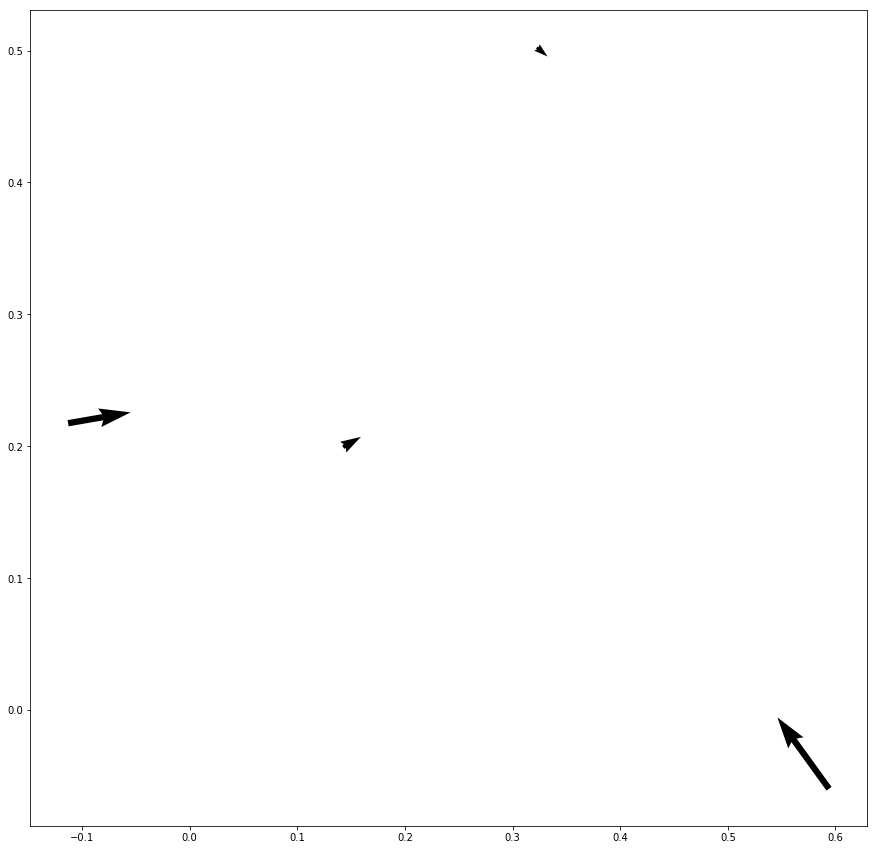

In [6]:
# plot direction field
dirs = final_hand_coords - hand_coords
dir_fig, dir_ax = plt.subplots(figsize=(15,15))
q = dir_ax.quiver(hand_coords[:,0], hand_coords[:,1], dirs[:,0], dirs[:,1])
plt.show()

In [25]:
plant_data = all_plant_data[1]
theta_s = plant_data[:,0]
theta_e = plant_data[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# coordinates of hand and elbow    
xe = np.cos(theta_s)*l1
ye = np.sin(theta_s)*l1
xh = xe + np.cos(phi)*l2
yh = ye + np.sin(phi)*l2
print("xh[0]=%f, yh[0]=%f"%(xh[0],yh[0]))
print("xh[-1]=%f, yh[-1]=%f"%(xh[-1],yh[-1]))

xh[0]=0.596426, yh[0]=-0.029433
xh[-1]=0.583874, yh[-1]=0.043188


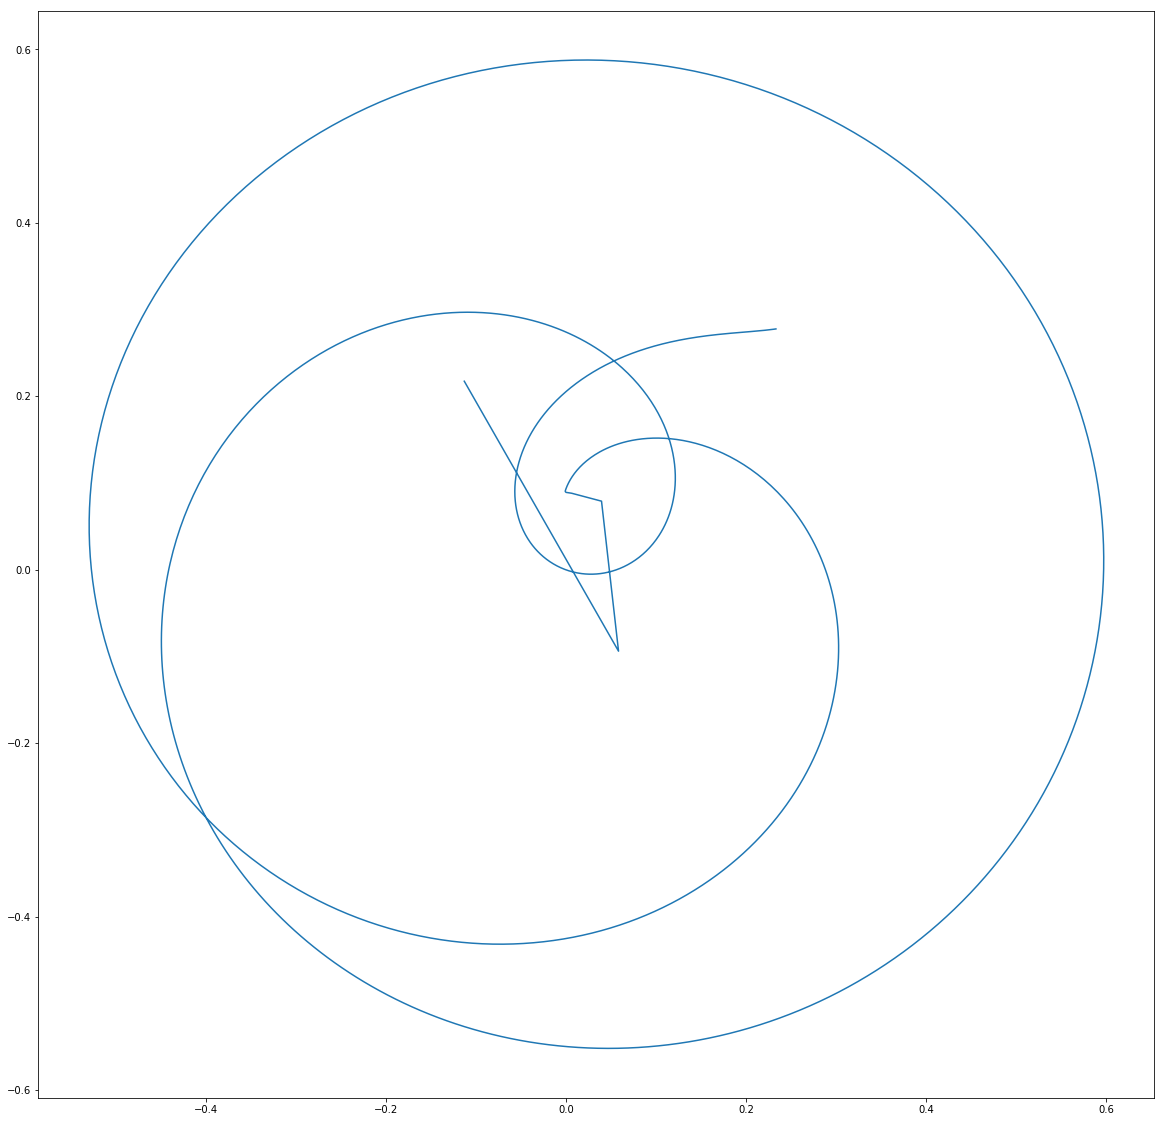

In [13]:
# plot trajectories

l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
fig = plt.figure(figsize=(20,20))
for plant_data in [all_plant_data[3]]:
    # angles of shoulder and elbow
    theta_s = plant_data[:,0]
    theta_e = plant_data[:,2]
    phi = theta_s + theta_e # elbow angle wrt x axis
    # coordinates of hand and elbow    
    xe = np.cos(theta_s)*l1
    ye = np.sin(theta_s)*l1
    xh = xe + np.cos(phi)*l2
    yh = ye + np.sin(phi)*l2
    plt.plot(xh,yh)
plt.show()
    

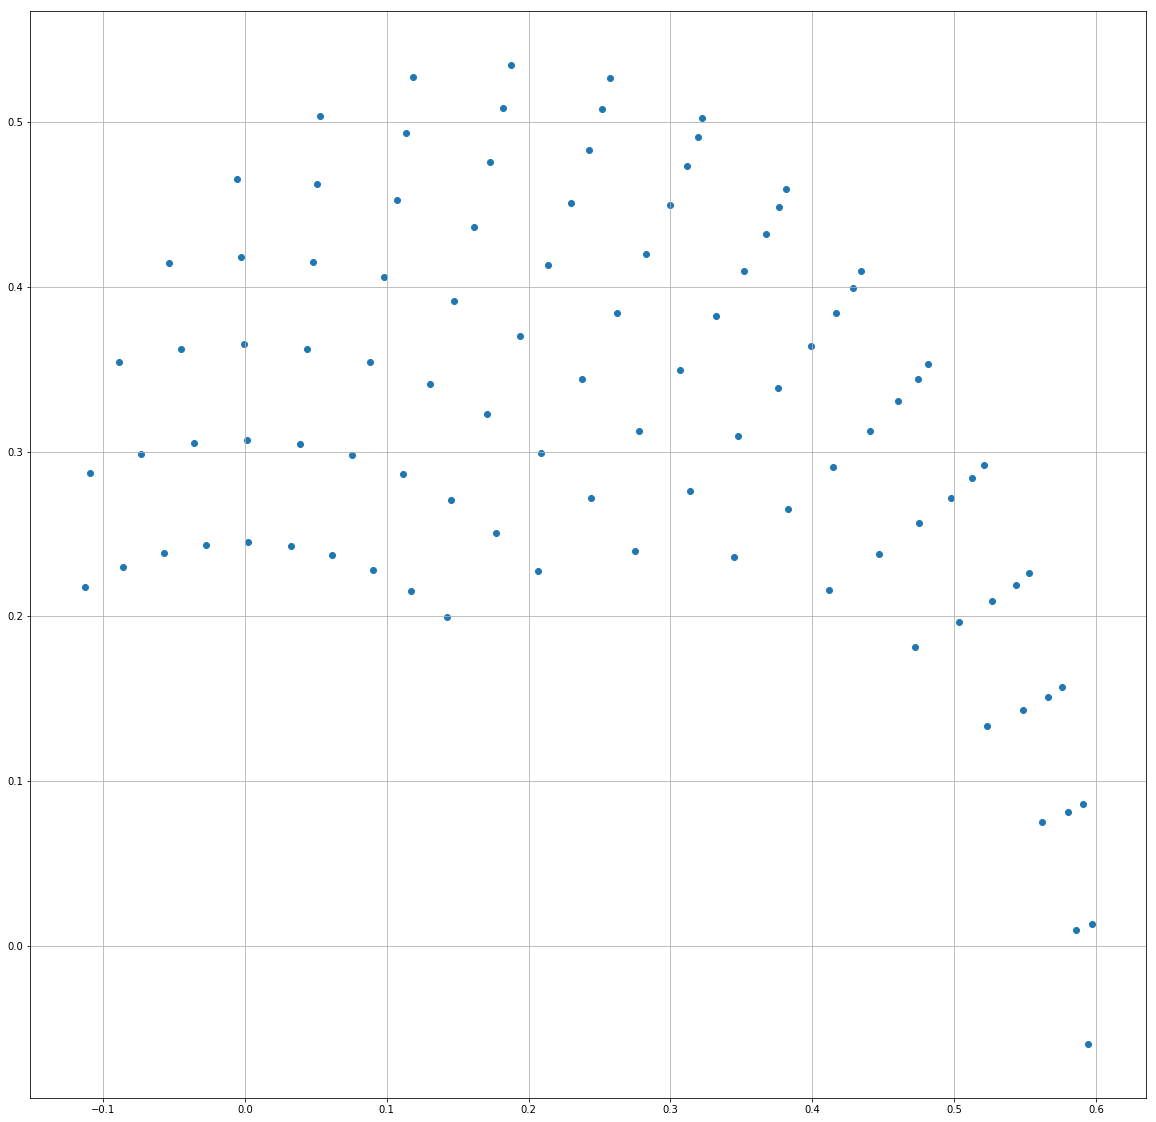

In [8]:
# plot da grid
grid_fig = plt.figure(figsize=(20,20))
plt.scatter(hand_coords[:,0], hand_coords[:,1])
plt.grid()
plt.show()

shoulder angle: 0.026316, shoulder vel: 1.588087


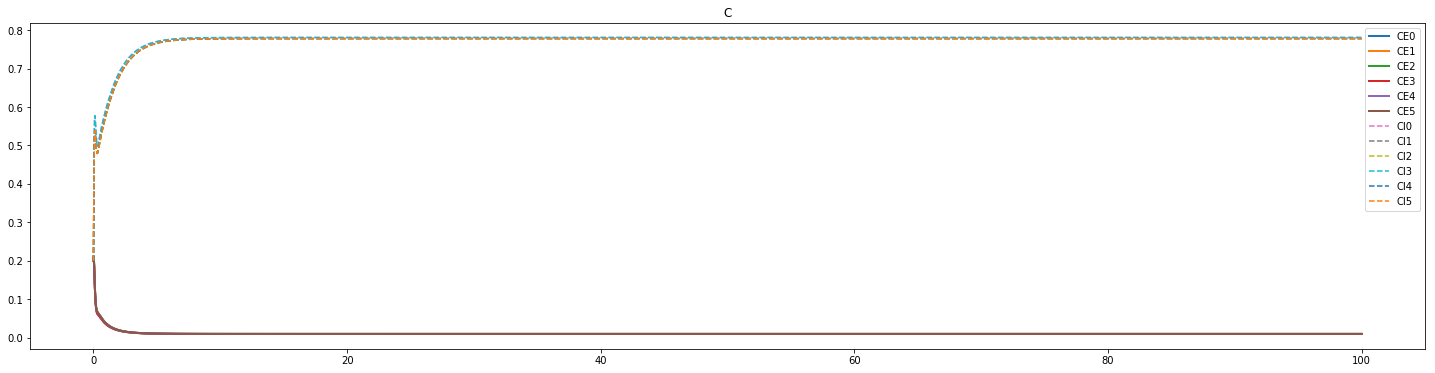

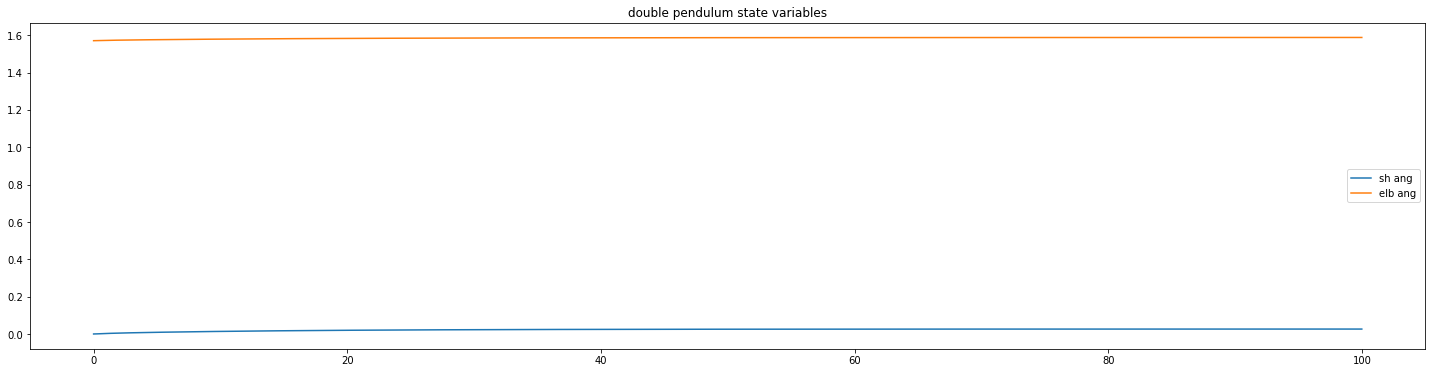

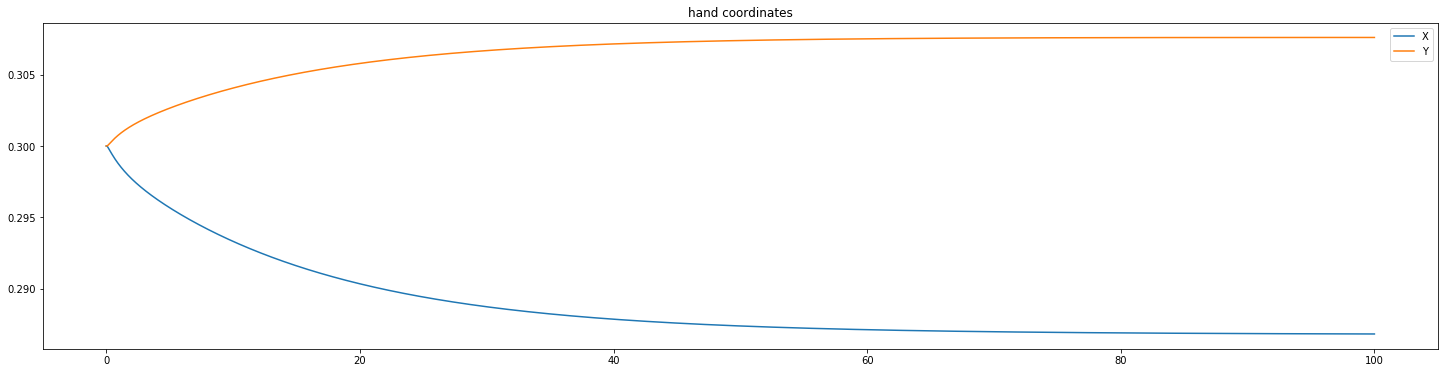

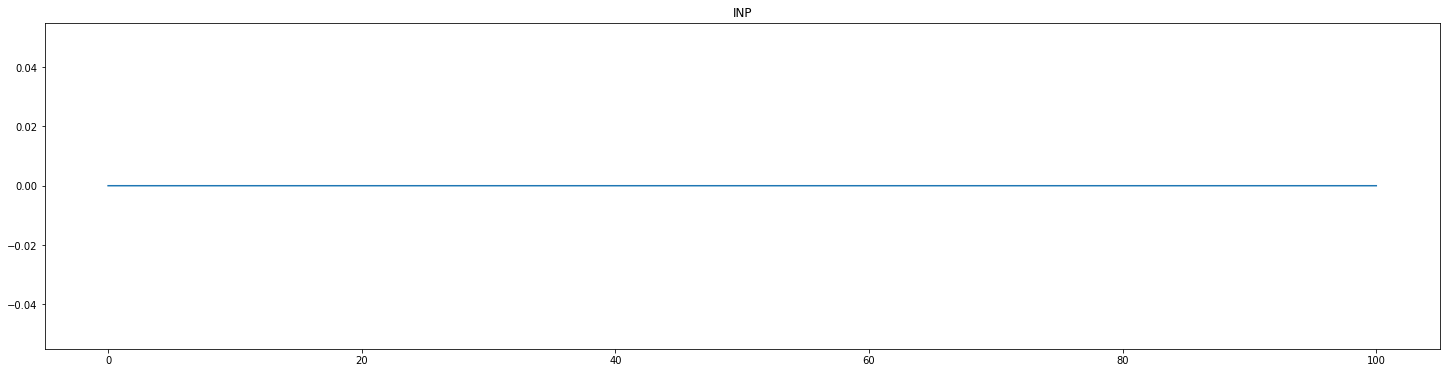

In [6]:
arm_activs = plant_data[P]
fs = (25,6)
# C
C_fig = plt.figure(figsize=fs)
CE_data = np.array(data[CE])
CI_data = np.array(data[CI])
plt.plot(times, CE_data.transpose(), linewidth=2)
plt.plot(times, CI_data.transpose(), '--')
C_legends = ['CE'+str(i) for i in range(len(CE))]
C_legends += ['CI'+str(i) for i in range(len(CI))]
plt.legend(C_legends)
plt.title('C')

# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

plant = net.plants[P]
# modified copy-paste of plt.upd_ip_impl
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
coords_fig = plt.figure(figsize=fs)
plt.plot(times, c_hand)

plt.title('hand coordinates')
plt.legend(['X', 'Y'])

inp_fig = plt.figure(figsize=fs)
inp_data = np.array(data[INP])[0]
plt.plot(times, inp_data)
#plt.plot(times, 0.8*np.ones_like(times), 'k--')
plt.title('INP')

plt.show()

AL_data:
[0.06039584 0.06083435 0.06083028 0.06042526 0.06078016 0.06072541]
Ib avg for muscle 0= 0.06427090608438277
Ia avg for muscle 0= 0.0992541653549843
II avg for muscle 0= 0.26616869417802397
Ib avg for muscle 1= 0.07680598833676873
Ia avg for muscle 1= 0.11160985759722103
II avg for muscle 1= 0.24186564764726112
Ib avg for muscle 2= 0.0737860356627975
Ia avg for muscle 2= 0.11287242337821535
II avg for muscle 2= 0.23683561718858936
Ib avg for muscle 3= 0.06221067789485223
Ia avg for muscle 3= 0.10337397873525794
II avg for muscle 3= 0.27416283076186043
Ib avg for muscle 4= 0.07806484630342457
Ia avg for muscle 4= 0.09978199692808747
II avg for muscle 4= 0.21376542752478003
Ib avg for muscle 5= 0.07979712952510046
Ia avg for muscle 5= 0.11508195391300942
II avg for muscle 5= 0.24464112709302968


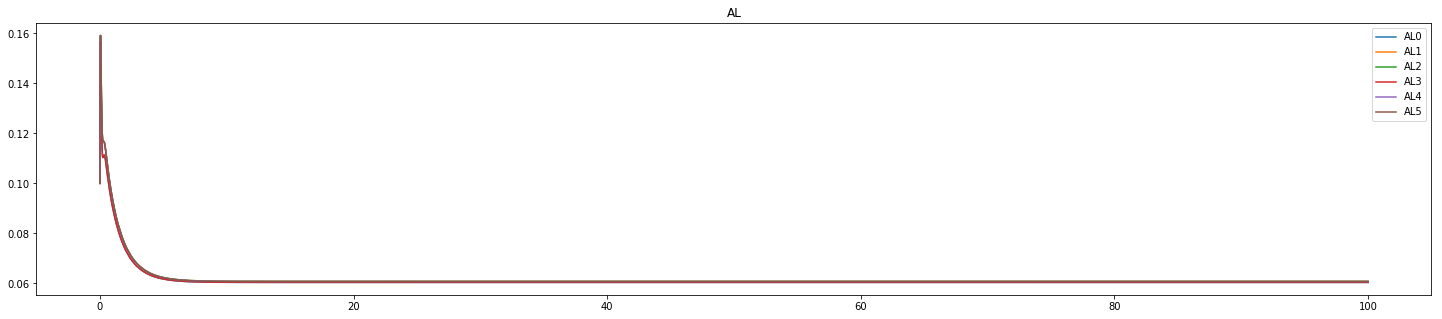

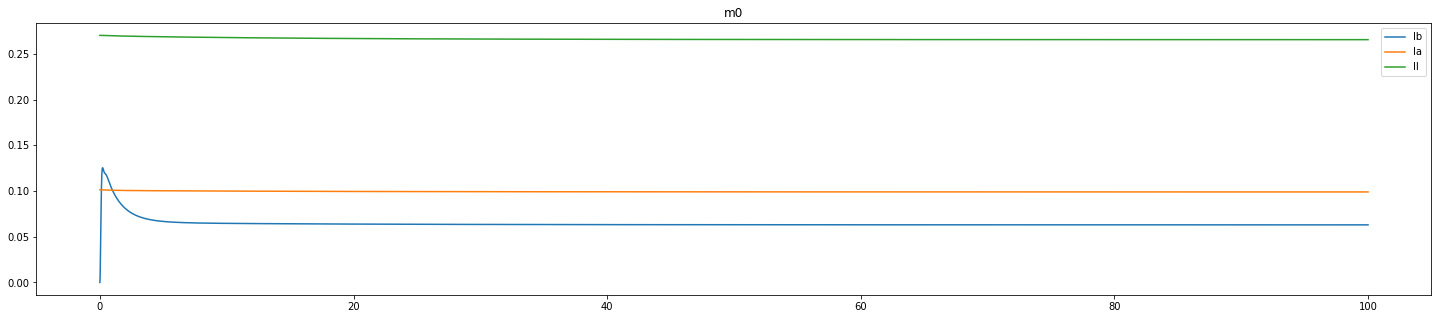

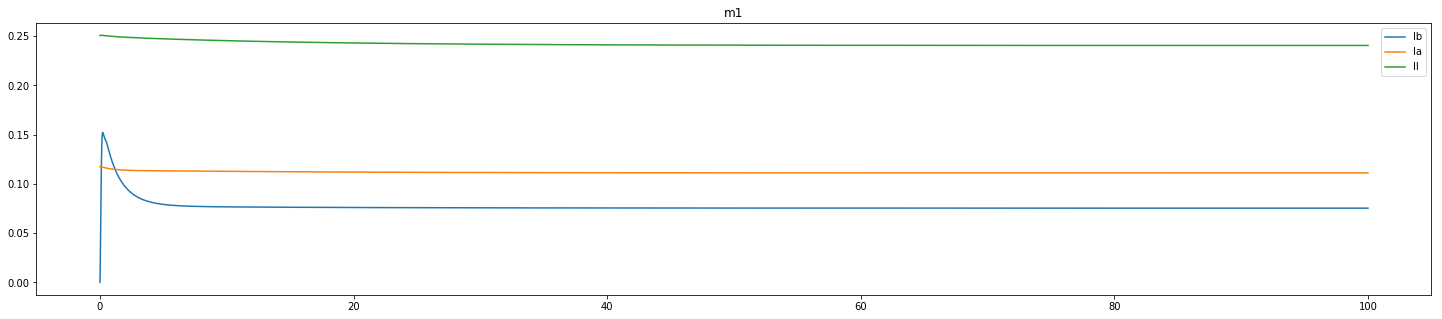

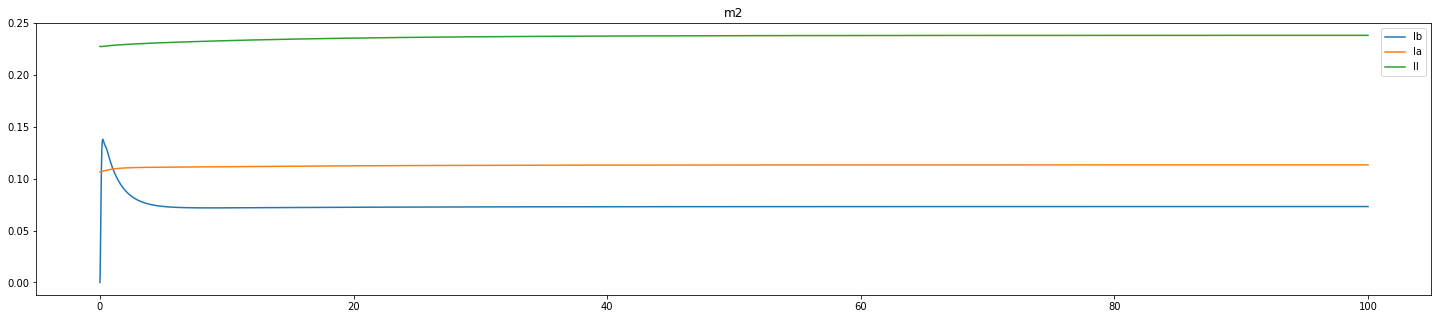

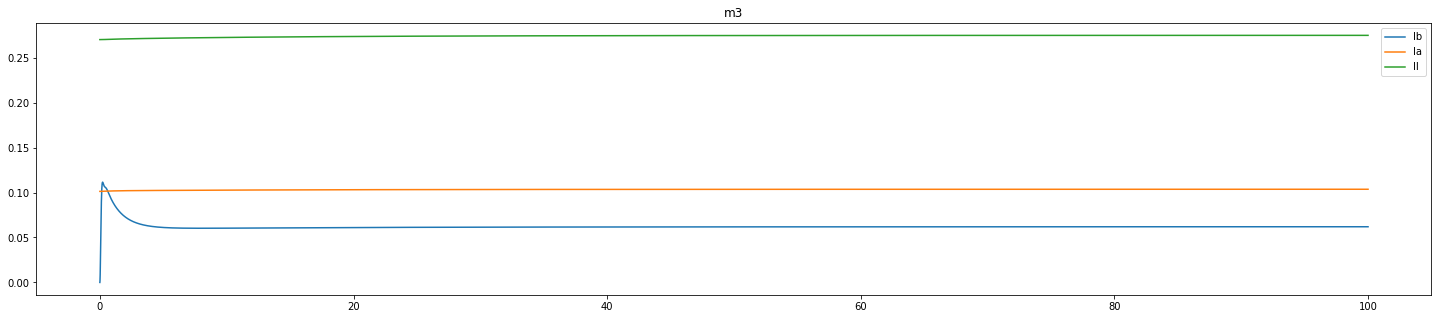

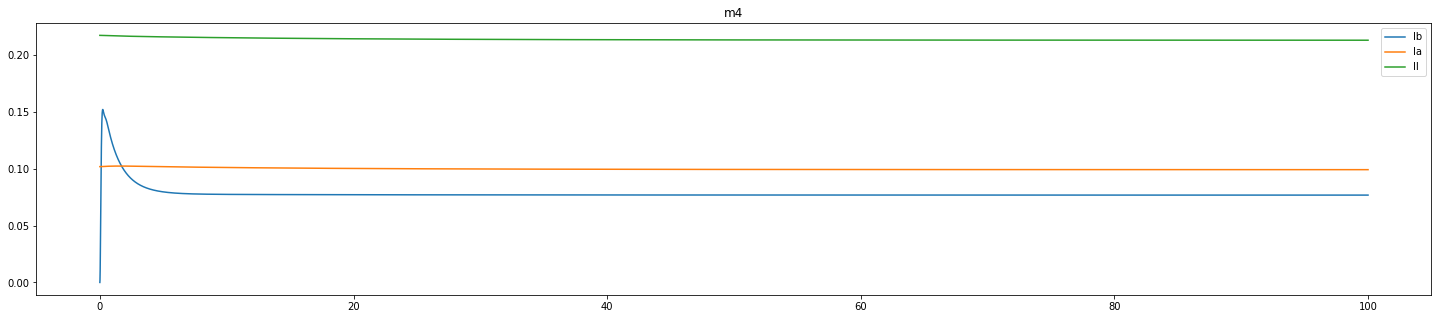

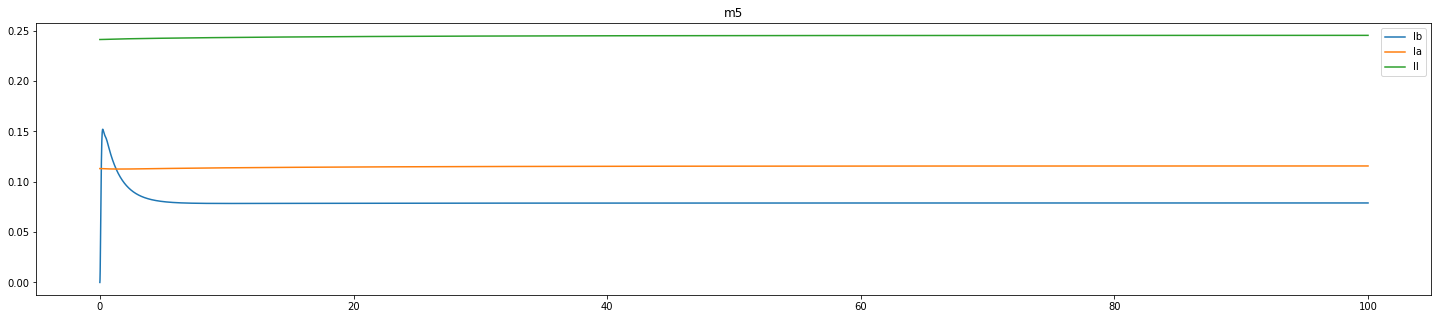

In [7]:
# Alpha units
fs2 =(25,5)
AL_fig = plt.figure(figsize=fs2)
AL_data = np.array(data[AL])
plt.plot(times, AL_data.transpose())
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
#fs = (20,5)
legs = ['Ib', 'Ia', 'II']

for i in range(6):
    next_fig = plt.figure(figsize=fs2)
    Ib = arm_activs[:,22+i]
    Ia = arm_activs[:,28+i]
    II = arm_activs[:,34+i]
    plt.plot(times, Ib, times, Ia, times, II)
    #plt.plot(times, Ib)
    plt.legend(legs)
    plt.title('m' + str(i))
    print('Ib avg for muscle '+ str(i) + '= ' + str(np.mean(Ib)))
    print('Ia avg for muscle '+ str(i) + '= ' + str(np.mean(Ia)))
    print('II avg for muscle '+ str(i) + '= ' + str(np.mean(II)))
plt.show()

---

In [6]:
#Animation of the arm and muscles
%matplotlib widget
from numpy import cos, sin
from matplotlib.animation import FuncAnimation

arm_activs = plant_data[0]
#arm_activs = all_plant_data[3]
# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
acts = np.array(data[1])
ipx = data[ipx_track]
ipy = data[ipy_track]
ten = arm_activs[:, np.array(range(4,10))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2
# creating the figure and axis
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()
# creating lines and points
line, = ax.plot([], [], 'o-b', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
# preparing a colormap for the tensions
ten_max = max(ten.max(), 1e-5)
ten_min = min(ten.min(), -1e-5)
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = frame*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    cur_idx = int(cur_time/t_pres) + strt_idx
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    
    return line, points, mus_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 20), init_func=init, blit=True, interval=20)

plt.show()

FigureCanvasNbAgg()

In [8]:
# checking some connections

print("Connections to spinal units")
for idx, syn in enumerate(net.syns[CE[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in INP:
        pre_pop = 'INP'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CE, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

for idx, syn in enumerate(net.syns[CI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in INP:
        pre_pop = 'INP'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CI, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")


print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in AL:
        pre_pop = 'AL'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
print("-------------------------\n")



Connections to spinal units
0) CI (12) --> CE, w=-4.000000, port=2, plant_out=None
1) CE (7) --> CE, w=0.500000, port=1, plant_out=None
2) CI (13) --> CE, w=0.000000, port=2, plant_out=None
3) CE (8) --> CE, w=0.000000, port=1, plant_out=None
4) CI (14) --> CE, w=0.000000, port=2, plant_out=None
5) CE (9) --> CE, w=0.000000, port=1, plant_out=None
6) CI (15) --> CE, w=0.000000, port=2, plant_out=None
7) CE (10) --> CE, w=0.500000, port=1, plant_out=None
8) CI (16) --> CE, w=0.000000, port=2, plant_out=None
9) CE (11) --> CE, w=0.000000, port=1, plant_out=None
10) CI (17) --> CE, w=0.000000, port=2, plant_out=None
11) INP (18) --> CE, w=1.000000, port=0, plant_out=None
-------------------------

0) CE (6) --> CI, w=1.000000, port=2, plant_out=None
1) CE (7) --> CI, w=0.000000, port=2, plant_out=None
2) CI (13) --> CI, w=0.000000, port=1, plant_out=None
3) CE (8) --> CI, w=0.500000, port=2, plant_out=None
4) CI (14) --> CI, w=0.000000, port=1, plant_out=None
5) CE (9) --> CI, w=2.000000,

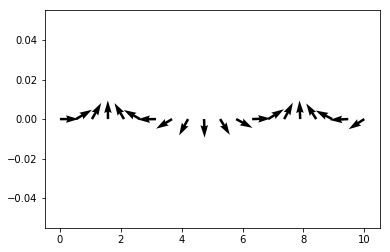

In [10]:
x = np.linspace(0,10,20)
y = np.zeros_like(x)
u = np.cos(x)
v = np.sin(x)
fig, ax = plt.subplots()
#q = ax.quiver(X, Y, U, V)
q = ax.quiver(x,y,u,v)
plt.show()

In [5]:
# SIMPLE SIMULATION
net.plants[0].place_hand([0.5, 0.15])
start_time = time.time()
times, data, plant_data  = net.flat_run(50.)
#times, data, plant_data  = net.run(40.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)
#Execution time is 8.687349319458008 seconds  << before sc_inp_sum_mp, flat_run(5.)

/home/z/projects/draculab/network.py:916: UserWarning: Integration method odeint substituted by Forward Euler in some units
  ' substituted by Forward Euler in some units', UserWarning)


Execution time is 53.31408667564392 seconds
